In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("traffic.csv")
data.head()

DateTime  Junction  Vehicles           ID
0  2015-11-01 00:00:00         1        15  20151101001
1  2015-11-01 01:00:00         1        13  20151101011
2  2015-11-01 02:00:00         1        10  20151101021
3  2015-11-01 03:00:00         1         7  20151101031
4  2015-11-01 04:00:00         1         9  20151101041

In [3]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  48120 non-null  datetime64[ns]
 1   Junction  48120 non-null  int64         
 2   Vehicles  48120 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 1.1 MB


In [9]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

DateTime  Junction  Vehicles  Year  Month  Date_no  Hour     Day
0 2015-11-01 00:00:00         1        15  2015     11        1     0  Sunday
1 2015-11-01 01:00:00         1        13  2015     11        1     1  Sunday
2 2015-11-01 02:00:00         1        10  2015     11        1     2  Sunday
3 2015-11-01 03:00:00         1         7  2015     11        1     3  Sunday
4 2015-11-01 04:00:00         1         9  2015     11        1     4  Sunday

IndexError: ignored

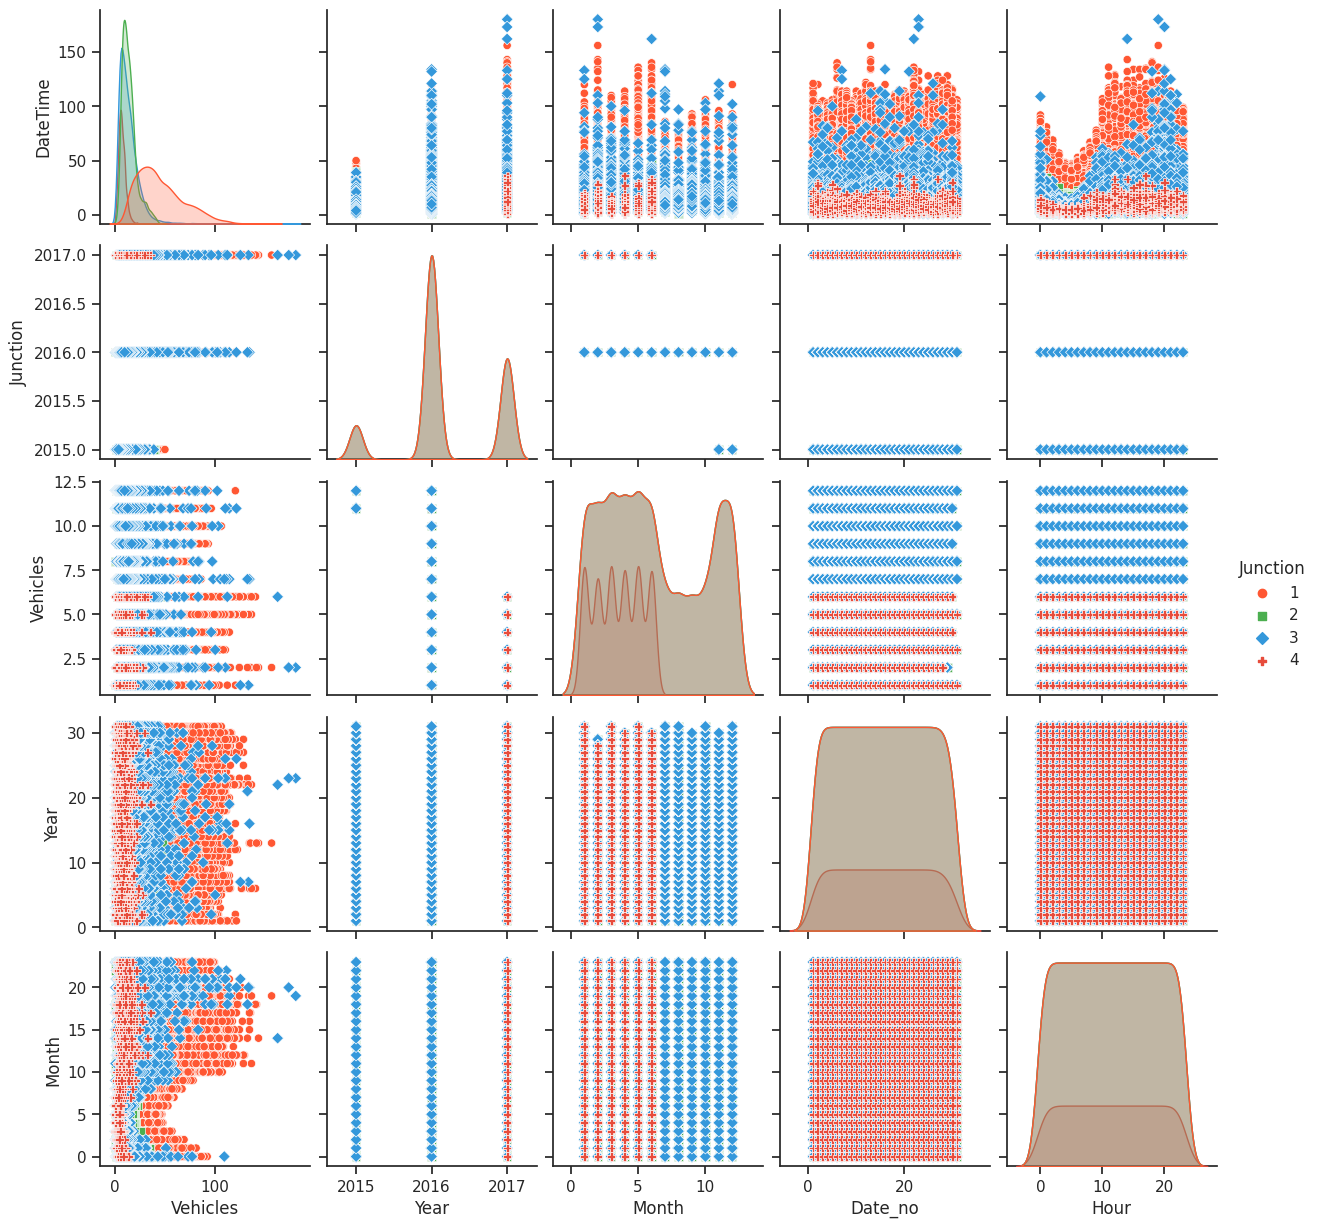

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="ticks")
pair_plot = sns.pairplot(data=df, hue="Junction", palette=colors, diag_kind="kde", markers=["o", "s", "D", "P"])

for i in range(len(df.columns) - 1):
    for j in range(len(df.columns) - 1):
        xlabel = df.columns[j]
        ylabel = df.columns[i]
        if i == len(df.columns) - 2:
            pair_plot.axes[i, j].set_xlabel(xlabel)
        if j == 0:
            pair_plot.axes[i, j].set_ylabel(ylabel)

pair_plot.fig.suptitle("Pairwise Analysis of Traffic Data", y=1.02, fontsize=16)
pair_plot._legend.set_title("Junction")
pair_plot._legend.set_fontsize(10)

plt.show()


In [13]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

In [32]:
df_1 = df_J[('Vehicles', 1)].copy()
df_2 = df_J[('Vehicles', 2)].copy()
df_3 = df_J[('Vehicles', 3)].copy()
df_4 = df_J[('Vehicles', 4)].copy()

df_1.dropna(inplace=True)
df_2.dropna(inplace=True)
df_3.dropna(inplace=True)
df_4.dropna(inplace=True)

df_1.reset_index(drop=True, inplace=True)
df_2.reset_index(drop=True, inplace=True)
df_3.reset_index(drop=True, inplace=True)
df_4.reset_index(drop=True, inplace=True)

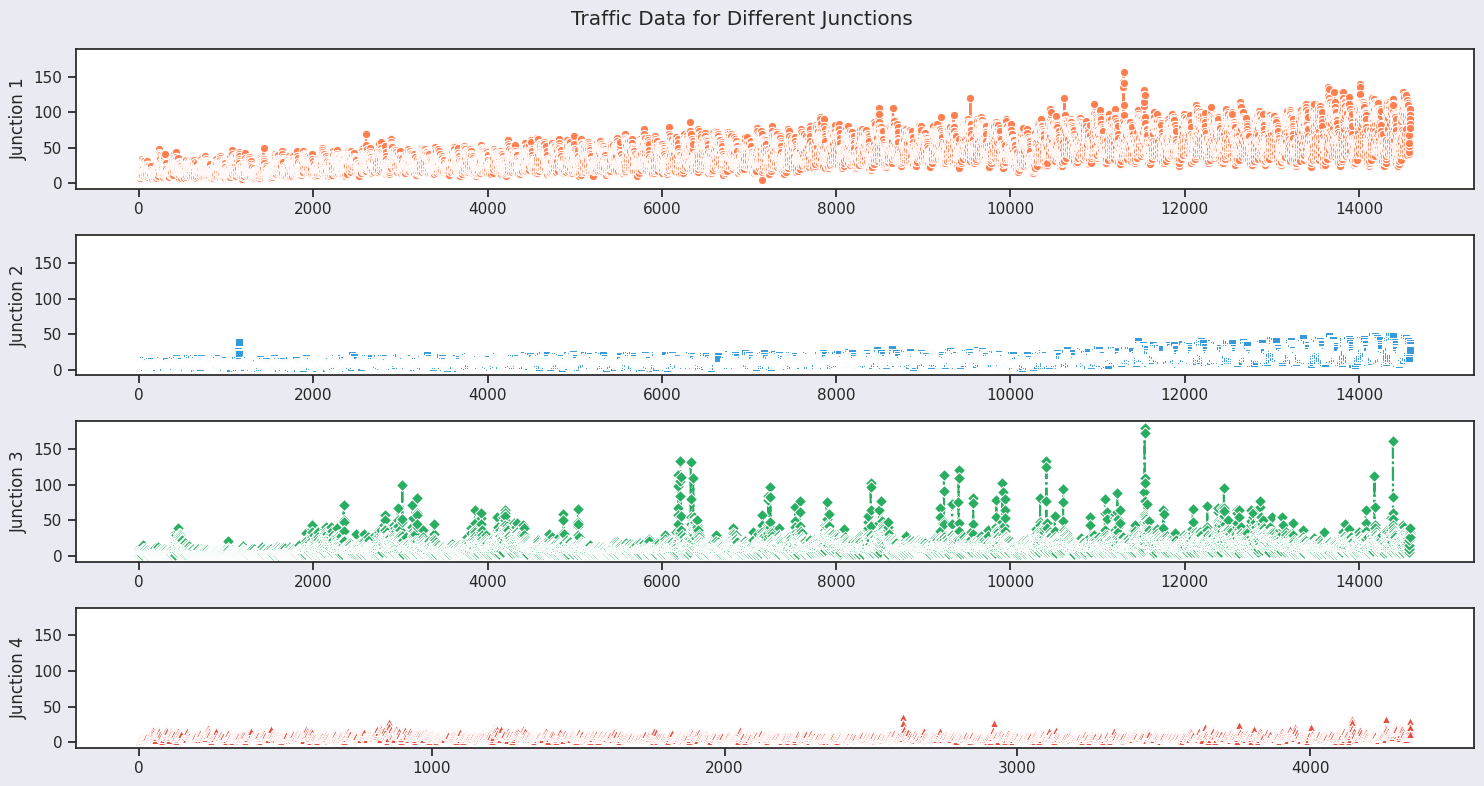

In [34]:
def Sub_Plots4_custom(df_1, df_2, df_3, df_4, title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8), facecolor="#EAEAF2", sharey=True)
    fig.suptitle(title)

    custom_colors = ["#FF7F50", "#3498db", "#27ae60", "#e74c3c"]

    # Junction 1
    sns.lineplot(ax=axes[0], data=df_1, color=custom_colors[0], marker="o", linestyle="-")
    axes[0].set(ylabel="Junction 1")

    # Junction 2
    sns.lineplot(ax=axes[1], data=df_2, color=custom_colors[1], marker="s", linestyle="--")
    axes[1].set(ylabel="Junction 2")

    # Junction 3
    sns.lineplot(ax=axes[2], data=df_3, color=custom_colors[2], marker="D", linestyle="-.")
    axes[2].set(ylabel="Junction 3")

    # Junction 4
    sns.lineplot(ax=axes[3], data=df_4, color=custom_colors[3], marker="^", linestyle=":")
    axes[3].set(ylabel="Junction 4")

    for ax in axes:
        ax.set_facecolor("#FFFFFF")

    plt.tight_layout()

Sub_Plots4_custom(df_1, df_2, df_3, df_4, "Traffic Data for Different Junctions")


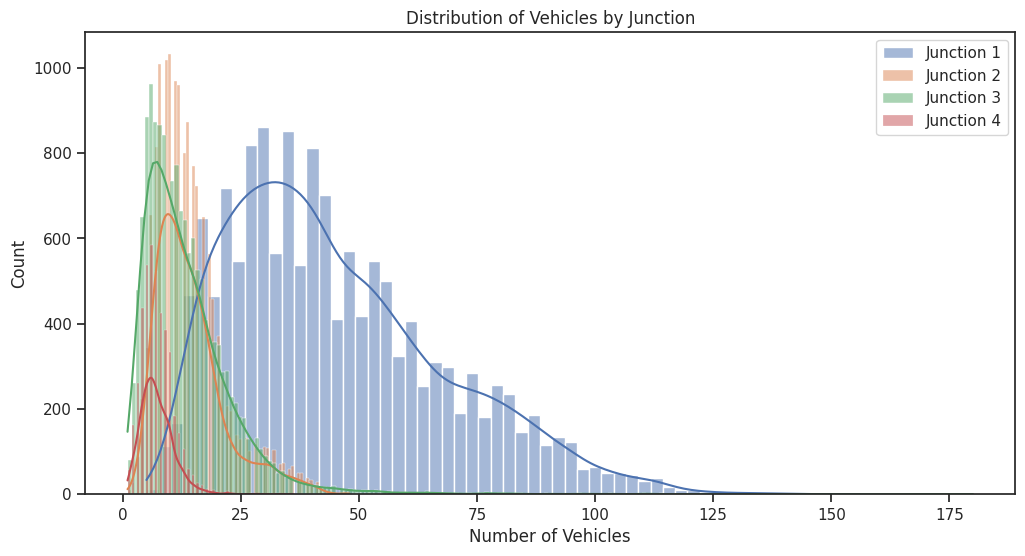

In [14]:
plt.figure(figsize=(12, 6))
for junction in df['Junction'].unique():
    sns.histplot(df[df['Junction'] == junction]['Vehicles'], label=f'Junction {junction}', kde=True)
plt.title("Distribution of Vehicles by Junction")
plt.xlabel("Number of Vehicles")
plt.legend()
plt.show()

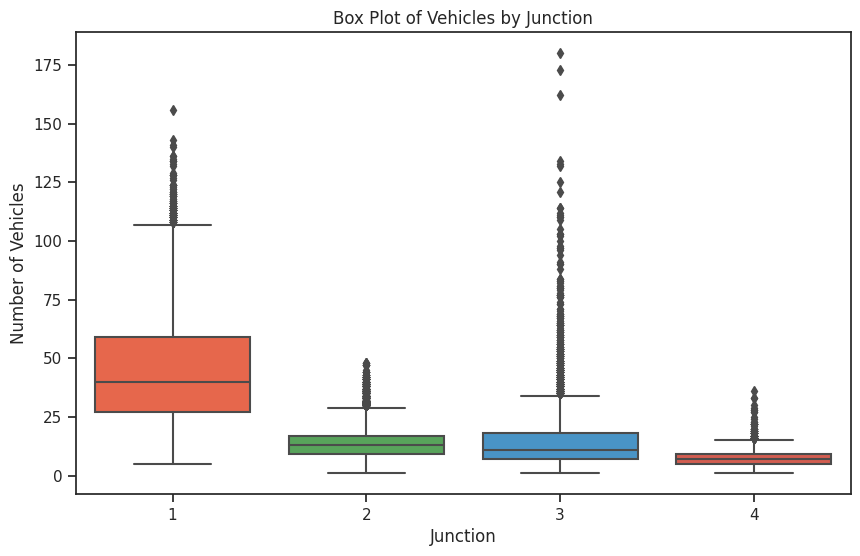

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Junction', y='Vehicles', data=df, palette=colors)
plt.title("Box Plot of Vehicles by Junction")
plt.xlabel("Junction")
plt.ylabel("Number of Vehicles")
plt.show()

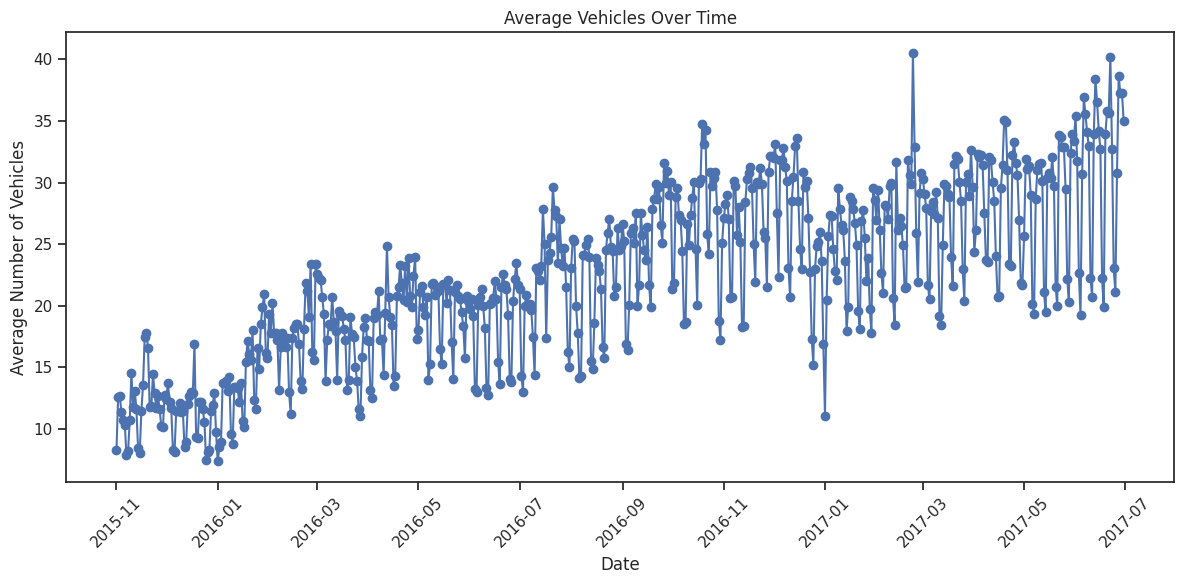

In [16]:
plt.figure(figsize=(12, 6))
df['Date'] = df['DateTime'].dt.date
df_avg_date = df.groupby('Date')['Vehicles'].mean()
plt.plot(df_avg_date.index, df_avg_date.values, marker='o', linestyle='-', color='b')
plt.title("Average Vehicles Over Time")
plt.xlabel("Date")
plt.ylabel("Average Number of Vehicles")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

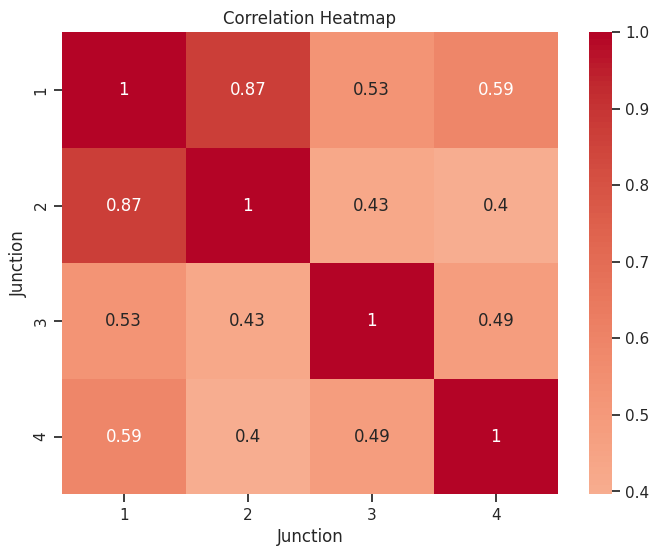

In [17]:
plt.figure(figsize=(8, 6))
corr_matrix = df.pivot_table(index='DateTime', columns='Junction', values='Vehicles').corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [19]:
import plotly.express as px

fig = px.line(df, x='DateTime', y='Vehicles', color='Junction',
              title='Interactive Time Series of Vehicles by Junction')
fig.update_xaxes(title_text='Date')
fig.update_yaxes(title_text='Number of Vehicles')
fig.show()

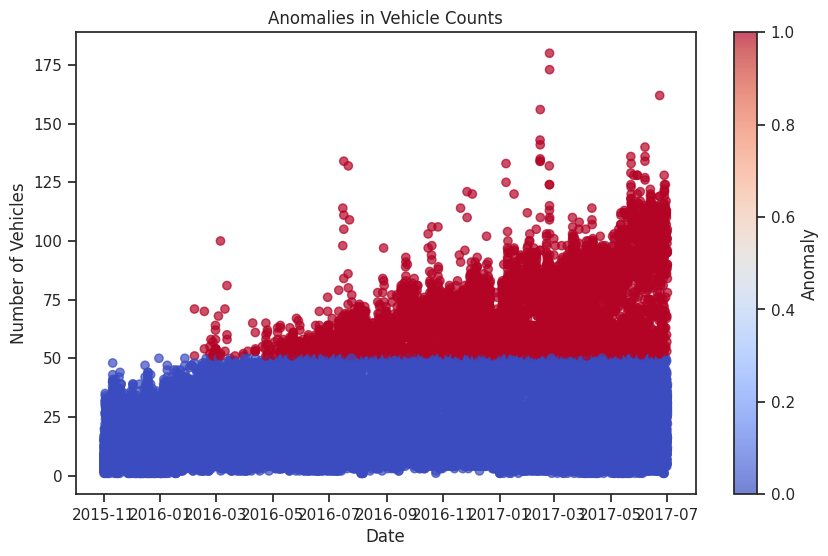

In [20]:
import numpy as np

threshold = 50
df['Anomaly'] = np.where(df['Vehicles'] > threshold, 1, 0)

plt.figure(figsize=(10, 6))
plt.scatter(df['DateTime'], df['Vehicles'], c=df['Anomaly'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label='Anomaly')
plt.title('Anomalies in Vehicle Counts')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.show()

In [21]:
import plotly.graph_objects as go

fig = go.Figure()

for junction in df['Junction'].unique():
    df_junction = df[df['Junction'] == junction]
    fig.add_trace(go.Scatter(x=df_junction['DateTime'], y=df_junction['Vehicles'],
                             mode='lines', name=f'Junction {junction}'))

fig.update_layout(title='Animated Time Series of Vehicles by Junction',
                  xaxis_title='Date', yaxis_title='Number of Vehicles',
                  updatemenus=[dict(type="buttons", x=0.1, y=1.15,
                                    buttons=[dict(label="Play",
                                                  method="animate",
                                                  args=[None, {"frame": {"duration": 300, "redraw": True},
                                                              "fromcurrent": True}]),
                                             dict(label="Pause",
                                                  method="animate",
                                                  args=[[None], {"frame": {"duration": 0, "redraw": False},
                                                              "mode": "immediate",
                                                              "transition": {"duration": 0}}])])])

frames = [go.Frame(data=[go.Scatter(x=df_junction['DateTime'], y=df_junction['Vehicles'],
                                     mode='lines', name=f'Junction {junction}')],
                   name=f'frame{j}')
          for j, junction in enumerate(df['Junction'].unique())]

fig.frames = frames

fig.show()

In [22]:
import pandas as pd

df['DateTime'] = pd.to_datetime(df['DateTime'])

df['Year'] = df['DateTime'].dt.year
df['Month'] = df['DateTime'].dt.month
df['Day'] = df['DateTime'].dt.day
df['Hour'] = df['DateTime'].dt.hour
df['DayOfWeek'] = df['DateTime'].dt.dayofweek
df['IsWeekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)  # 5 and 6 correspond to Saturday and Sunday

print(df.head())

             DateTime  Junction  Vehicles  Year  Month  Date_no  Hour  Day  \
0 2015-11-01 00:00:00         1        15  2015     11        1     0    1   
1 2015-11-01 01:00:00         1        13  2015     11        1     1    1   
2 2015-11-01 02:00:00         1        10  2015     11        1     2    1   
3 2015-11-01 03:00:00         1         7  2015     11        1     3    1   
4 2015-11-01 04:00:00         1         9  2015     11        1     4    1   

         Date  Anomaly  DayOfWeek  IsWeekend  
0  2015-11-01        0          6          1  
1  2015-11-01        0          6          1  
2  2015-11-01        0          6          1  
3  2015-11-01        0          6          1  
4  2015-11-01        0          6          1  


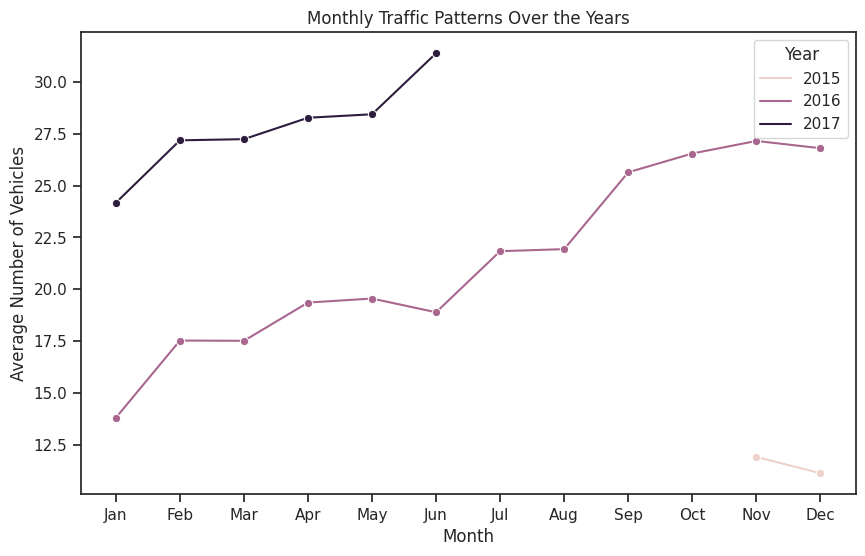

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

df_monthly = df.groupby(['Year', 'Month'])['Vehicles'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_monthly, x='Month', y='Vehicles', hue='Year', marker='o')
plt.title('Monthly Traffic Patterns Over the Years')
plt.xlabel('Month')
plt.ylabel('Average Number of Vehicles')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.show()

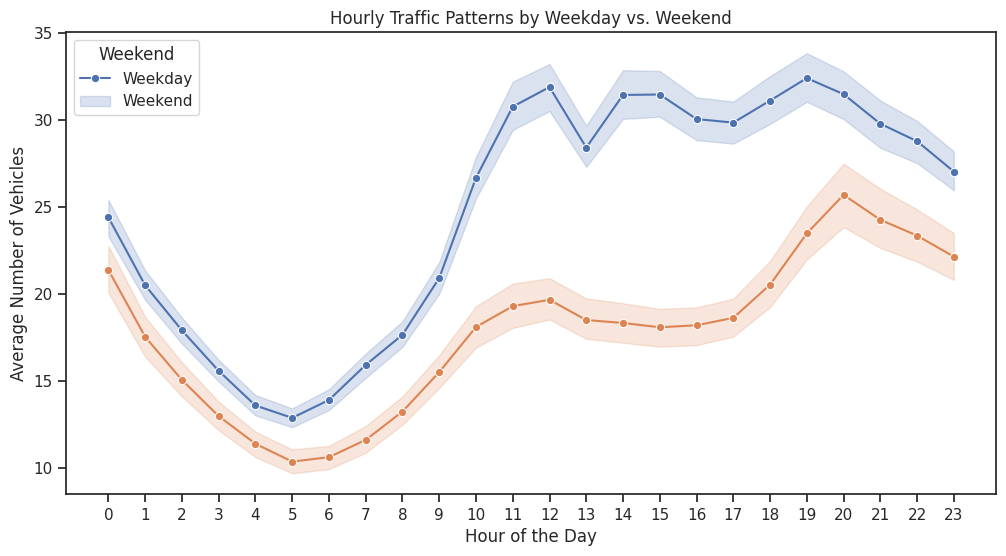

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Hour', y='Vehicles', hue='IsWeekend', marker='o')
plt.title('Hourly Traffic Patterns by Weekday vs. Weekend')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Vehicles')
plt.xticks(range(24))
plt.legend(title='Weekend', labels=['Weekday', 'Weekend'])
plt.show()

Epoch 1/50
1203/1203 [==============================] - 4s 2ms/step - loss: 659.1852
Epoch 2/50
1203/1203 [==============================] - 2s 2ms/step - loss: 455.0043
Epoch 3/50
1203/1203 [==============================] - 2s 2ms/step - loss: 449.7144
Epoch 4/50
1203/1203 [==============================] - 2s 2ms/step - loss: 446.7546
Epoch 5/50
1203/1203 [==============================] - 3s 2ms/step - loss: 446.6072
Epoch 6/50
1203/1203 [==============================] - 3s 2ms/step - loss: 446.3224
Epoch 7/50
1203/1203 [==============================] - 2s 2ms/step - loss: 445.2562
Epoch 8/50
1203/1203 [==============================] - 2s 2ms/step - loss: 445.3619
Epoch 9/50
1203/1203 [==============================] - 2s 2ms/step - loss: 444.9919
Epoch 10/50
1203/1203 [==============================] - 3s 2ms/step - loss: 444.5745
Epoch 11/50
1203/1203 [==============================] - 3s 2ms/step - loss: 443.6956
Epoch 12/50
1203/1203 [==============================] - 2s 2ms

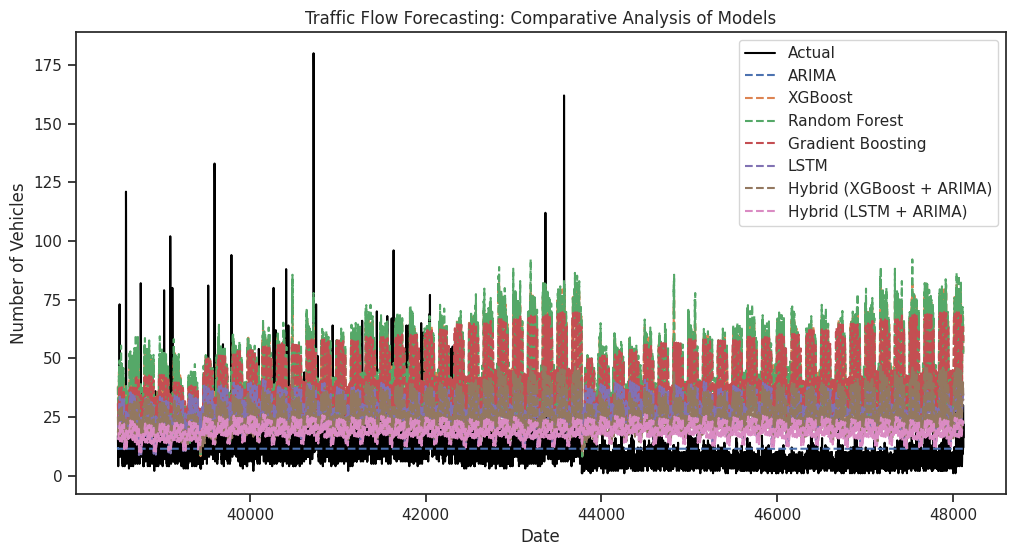

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df['DateTime'] = pd.to_datetime(df['DateTime'])
df['Date'] = df['DateTime'].dt.date
df['Hour'] = df['DateTime'].dt.hour
df['Weekday'] = df['DateTime'].dt.weekday

X = df[['Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'IsWeekend', 'Weekday']]
y = df['Vehicles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# ARIMA Model
arima_model = ARIMA(y_train, order=(5, 1, 0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(X_test))

# XGBoost Model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_forecast = xgb_model.predict(X_test)

# Random Forest Model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_forecast = rf_model.predict(X_test)

# Gradient Boosting Model
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)
gb_forecast = gb_model.predict(X_test)

# LSTM Model
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')

lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, verbose=1)
lstm_forecast = lstm_model.predict(X_test_lstm).flatten()

# Hybrid Models
hybrid_xgb_arima = (xgb_forecast + arima_forecast) / 2
hybrid_lstm_arima = (lstm_forecast + arima_forecast) / 2

models = ['ARIMA', 'XGBoost', 'Random Forest', 'Gradient Boosting', 'LSTM', 'Hybrid (XGBoost + ARIMA)', 'Hybrid (LSTM + ARIMA)']
forecasts = [arima_forecast, xgb_forecast, rf_forecast, gb_forecast, lstm_forecast, hybrid_xgb_arima, hybrid_lstm_arima]

for model, forecast in zip(models, forecasts):
    rmse = np.sqrt(mean_squared_error(y_test, forecast))
    print(f'{model} RMSE: {rmse:.2f}')

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', color='black')

for model, forecast in zip(models, forecasts):
    plt.plot(y_test.index, forecast, label=model, linestyle='dashed')

plt.title('Traffic Flow Forecasting: Comparative Analysis of Models')
plt.xlabel('Date')
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()
